# Neural Networks, gradient descent, and regression, no tears

In this notebook, we show how to use neural networks (NNs) with [PyTorch](https://pytorch.org/) to solve a linear regression problem using different gradient descent methods. The three gradient descent methods we will look at are

* batch gradient descent,
* stochastic gradient descent, and
* mini-batch gradient descent.

If you recall, ordinary least square (OLS) regression problems of the form $y = \beta + w_1 x_1 + \ldots + w_n x_n$ are solved through __maximum likelihood methods__. The weights, $w = \{w_1, \ldots, w_n\}$, of a regression model are estimated through a __loss function__. Initially, we guess what the weights are, and then we make predictions $\hat{y}$ based on the weights. The predictions $\hat{y}$ will differ from the true values $y$. The loss function is often written as follows $L(y, \hat{y}) = (y - \hat{y})^2$. The partial derivative of the loss function (with respect to the weights) helps us adjust the weights in direction (negative or positive direction) and magnitude (how much do we move). Typically, the weights are adjusted as follows.

$w^{*}_{j} = w_j - \alpha \frac{\partial L}{\partial w_j}$

where

* $w^{*}_{j}$ is the j-th new weight
* $w_j$ is the j-th current weight
* $\alpha$ is the learning rate
* $\frac{\partial L}{\partial w_j}$ is the partial derivative of the loss function $L$ with respect to the weight $w_j$

There are many ways to actually use the loss function and thus, errors, to adjust the weights. 

* We can feed one example $x = \{ x_1, \ldots, x_n \}$ to the model to get a prediction $\hat{y}$, compute the error (loss), and then use the error to adjust the weights. Typically, we want to randomize the inputs $x$ before feeding them one at a time to the model. We feed one example at a time until we run out of examples. This approach is called stochastic gradient descent.
* We can feed all examples to the model to get a vector of predictions, compute the average error, and then use this average error to adjust the weights. This approach is called batch gradient descent.
* We can feed a small number of examples to the model, compute the corresponding average error, and then use this average error to adjust the weights. Each of these small number of examples we feed into the model are called __batches__, and there are many ways to decide the size of the batch. We feed the model as many batches as we have until we run out of examples. This approach is called mini-batch gradient descent.

After we iterate over all examples, no matter the method (batch, stochastic, or mini-batch), this completion is termed an __epoch__; meaning, in one epoch, we have used all the training examples to adjust the weights. As you will see below, we need to run through many epochs when using NNs to learn the weights for a OLS regression model. All the NNs shown below will only have 2 layers, an input and output layer; so, the NN architectures are the same (identical). The difference is with training them through batch, stochastic, or mini-batch gradient descent.

# Simulate data

Let's simulate our data to following the equation $y = 5.0 + w_1 x_1 + \epsilon$, where 

* $x_1 \sim \mathcal{N}(2, 1)$, $x_1$ is sampled from a normal distribution of mean 2 and 1 standard deviation
* $\epsilon \sim \mathcal{N}(0, 1)$, $\epsilon$ is the error term and sampled from a normal distribution of mean 0 and 1 standard deviation
* $y \sim \mathcal{N}(5.0 + w_1 x_1)$, $y$ is sampled from a normal distribution of mean $5.0 + w_1 x_1$ and 1 standard deviation

Note that we sampled 1,000 $x, y$ pairs. Our matrix to represent the input values $x$, however, has 2 columns; the first column represents the bias and all its values are 1; the second column represents the sampled $x$. Note also that once we have our data, we need to convert them to PyTorch tensors.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import torch
import torch.nn as nn
from torch import optim
from numpy.random import normal
from sklearn.metrics import r2_score

np.random.seed(37)

n = 1000
X = np.hstack([
        np.ones(n).reshape(n, 1), 
        normal(2.0, 1.0, n).reshape(n, 1)
    ])
y = normal(5.0 + 2.0 * X[:, 1], 1, n).reshape(n, 1) + normal(0, 1, n).reshape(n, 1)

X = torch.from_numpy(X).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.FloatTensor)

# Gradient descent

Here, we will define a 2 layers NN architecture, and apply the different gradient descent approaches. Note that we keep track of the losses and plot them out. We also estimated $R^2$ value for each model resulting from each of the approaches. Finally, we use Scikit-Learn's `LinearRegression` model to estimate the weights as well for a sanity check.

In [2]:
def plot_loss(loss_trace, title='Loss over epochs'):
    loss_df = pd.DataFrame(loss_trace, columns=['epoch', 'loss'])
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.plot(loss_df['epoch'], loss_df['loss'])
    ax.set_title(title)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

## Batch gradient descent

0
Parameter containing:
tensor([[ 3.0393,  2.7823]])


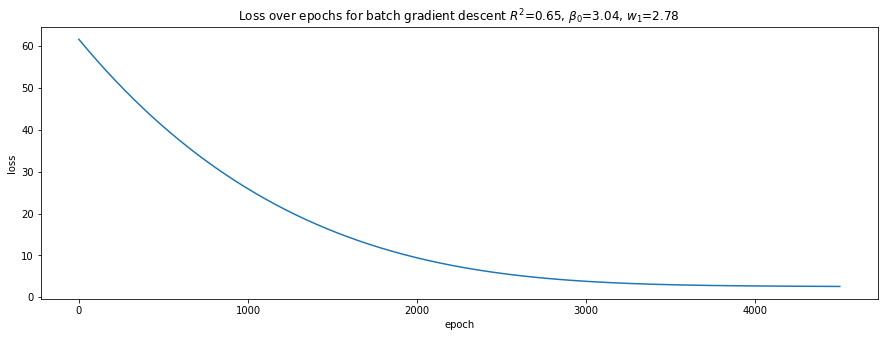

In [3]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=False)
)

loss_fn = torch.nn.MSELoss(size_average=True)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_trace = []

for epoch in range(4500):
    y_pred = model(X)
    
    loss = loss_fn(y_pred, y)
    loss_trace.append((epoch, loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
for i in range(len(model)):
    if hasattr(model[i], 'weight'):
        print(i)
        print(model[i].weight)
        
r2 = r2_score(model(X).data.numpy(), y.data.numpy())
b0 = model[0].weight[0, 0]
w1 = model[0].weight[0, 1]
plot_loss(loss_trace, r'Loss over epochs for batch gradient descent $R^2$={:.2f}, $\beta_0$={:.2f}, $w_1$={:.2f}'.format(r2, b0, w1))

## Stochastic gradient descent

0
Parameter containing:
tensor([[ 5.0064,  1.9857]])


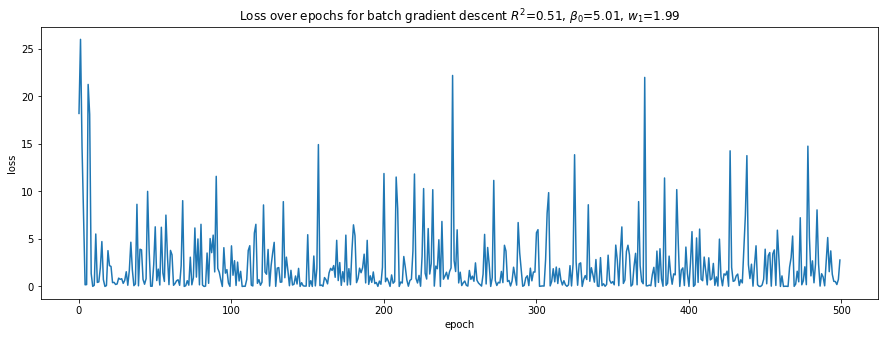

In [4]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=False)
)

loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_trace = []

for epoch in range(500):
    indices = list(range(n))
    np.random.shuffle(indices)

    for i in indices:
        y_pred = model(X[i])
        loss = loss_fn(y_pred, y[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_trace.append((epoch, loss.item()))
    
for i in range(len(model)):
    if hasattr(model[i], 'weight'):
        print(i)
        print(model[i].weight)
        
r2 = r2_score(model(X).data.numpy(), y.data.numpy())
b0 = model[0].weight[0, 0]
w1 = model[0].weight[0, 1]
plot_loss(loss_trace, r'Loss over epochs for batch gradient descent $R^2$={:.2f}, $\beta_0$={:.2f}, $w_1$={:.2f}'.format(r2, b0, w1))

## Mini-batch gradient descent

0
Parameter containing:
tensor([[ 4.6751,  2.1244]])


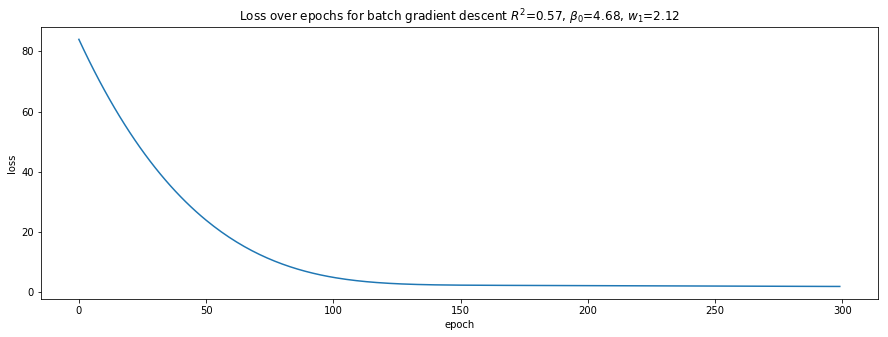

In [5]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=False)
)

loss_fn = torch.nn.MSELoss(size_average=True)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_trace = []

for epoch in range(300):
    start = 0
    batch_size = 32
    indices = list(range(n))

    while True:
        stop = start + batch_size
        if stop >= n:
            stop = n

        y_pred = model(X[indices])
        loss = loss_fn(y_pred, y[indices])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        start += batch_size
        if start >= n:
            break
    
    loss_trace.append((epoch, loss.item()))
            
for i in range(len(model)):
    if hasattr(model[i], 'weight'):
        print(i)
        print(model[i].weight)
        
r2 = r2_score(model(X).data.numpy(), y.data.numpy())
b0 = model[0].weight[0, 0]
w1 = model[0].weight[0, 1]
plot_loss(loss_trace, r'Loss over epochs for batch gradient descent $R^2$={:.2f}, $\beta_0$={:.2f}, $w_1$={:.2f}'.format(r2, b0, w1))

## Verify with Scikit-Learn Linear Model

In [6]:
from sklearn import linear_model

model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X.data.numpy(), y.data.numpy())
print(model.coef_)
print(r2_score(model.predict(X), y.data.numpy()))

[[5.0051513 1.9844325]]
0.5143195187191067


## Summary of results

Here are some things to note.

* Batch gradient descent takes many more epochs (4,500) to learn the weights and converge. Mini-batch gradient descent takes only 300 epochs, and stochastic gradient descent takes 500 epochs.
* Batch and mini-batch gradient descents' losses over epochs are smooth while stochastic gradient descent bounces up and down. This observation is no doubt related to randomization of the data.
* Stochastic gradient descent and Scikit-Learn's `LinearRegression` learn the intercept and weight that are closest to the model's true parameters, however, their $R^2$ are not the highest, and, in fact, are the lowest.
* The NN learned through batch gradient descent has the highest $R^2$ value, though the intercept and weight do not really resemble the model's true parameters.

# References

* [PyTorch with examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module)
* [Linear regression in x minutes using PyTorch](https://hackernoon.com/linear-regression-in-x-minutes-using-pytorch-8eec49f6a0e2)
* [PyTorch examples](https://github.com/jcjohnson/pytorch-examples#pytorch-tensors)
* [A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)
* [How to adjust learning rate](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

# Take a Look!

Take a look at [Dr. Arthur P. Dempster](https://en.wikipedia.org/wiki/Arthur_P._Dempster).